In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [69]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
for class_name in Base.classes.items():
    print(class_name)  

('station', <class 'sqlalchemy.ext.automap.station'>)
('measurement', <class 'sqlalchemy.ext.automap.measurement'>)


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [9]:
query = text("""SELECT * from station LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [10]:
query = text("""SELECT * from measurement LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
query = text("""Select max(date) from measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

<Figure size 1000x600 with 0 Axes>

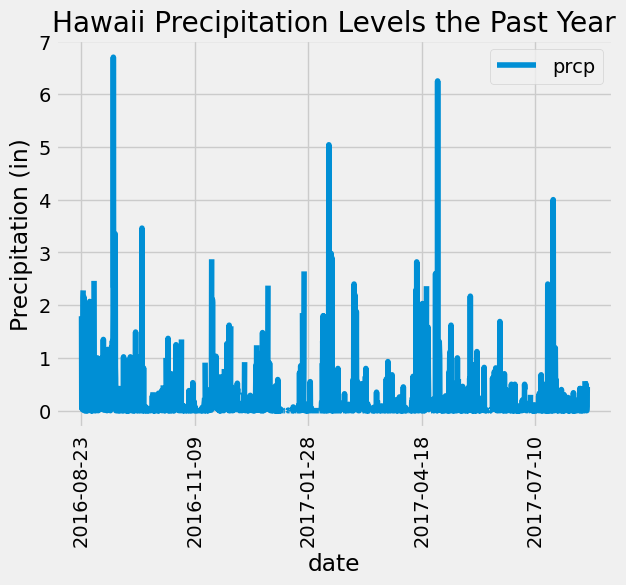

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23")
df = pd.DataFrame(rows)

# Sort the dataframe by date
df_sorted = df.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df_sorted.plot(x="date", y="prcp", rot=90)
plt.title("Hawaii Precipitation Levels the Past Year")
plt.ylabel("Precipitation (in)")
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Statistics meaning things like mean, and standard deviation
df_sorted.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
#query = text("""SELECT * from station""")
#df = pd.read_sql(query, con=conn)
#len(df)
session.query(func.count(Station.station)).all()

[(9,)]

In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
rows = session.query(Measurement.station, func.count(Measurement.id).label("count")).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
df1 = pd.DataFrame(rows)
df1

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs).label("lowest_temp"),
              func.max(Measurement.tobs).label("highest_temp"),
              func.avg(Measurement.tobs).label("average_temp")
             ).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [72]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= "2016-08-23").order_by(desc(Measurement.date)).all()
df2 = pd.DataFrame(active_station)
df2

,id,station,date,prcp,tobs
0,14959,USC00519281,2017-08-18,0.06,79.0
1,14958,USC00519281,2017-08-17,0.01,76.0
2,14957,USC00519281,2017-08-16,0.12,76.0
3,14956,USC00519281,2017-08-15,0.32,77.0
4,14955,USC00519281,2017-08-14,0.00,77.0
...,...,...,...,...,...
347,14612,USC00519281,2016-08-27,0.12,75.0
348,14611,USC00519281,2016-08-26,0.01,80.0
349,14610,USC00519281,2016-08-25,0.06,80.0
350,14609,USC00519281,2016-08-24,2.15,77.0


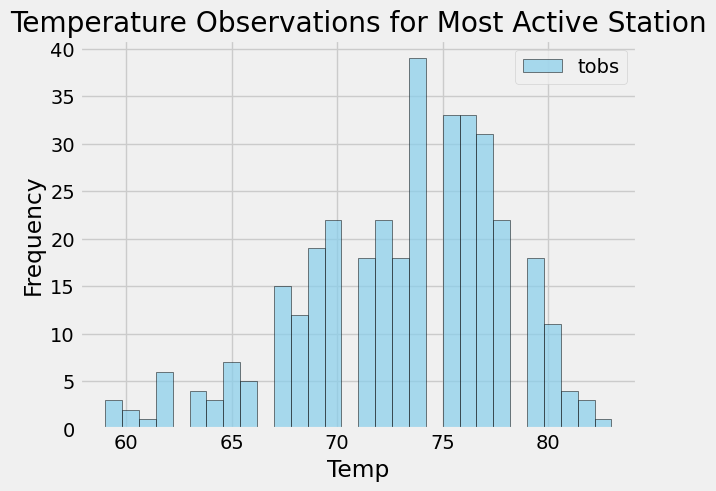

In [81]:
# Histogram

df2.plot.hist(y='tobs', bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Temperature Observations for Most Active Station")
plt.ylabel("Frequency")
plt.xlabel("Temp")
plt.show()

# Close Session

In [82]:
# Close Session
session.close()
conn.close()

In [83]:
engine.dispose()